In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow.keras as K
import tensorflow.keras.backend as Kback
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Load dataset

In [3]:
train_datagen = K.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.3)   

train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/train',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   shuffle=True,
                                                   batch_size = 64)
validation_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/train',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'validation',
                                                   shuffle=True,
                                                   batch_size = 64)


test_datagen = K.preprocessing.image.ImageDataGenerator(rescale = 1./255)   

test_dataset  = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/test',
                                                   target_size = (160,160),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   shuffle=True,
                                                   batch_size = 64)

Found 7007 images belonging to 20 classes.
Found 3003 images belonging to 20 classes.
Found 2000 images belonging to 20 classes.


# InceptionV3

In [4]:
input_layer = K.Input(shape=(160,160,3))
effnet_model = K.applications.InceptionV3(include_top = False, weights = "imagenet", input_tensor = input_layer)
for layer in effnet_model.layers:
    layer.trainable = False
for i, layer in enumerate(effnet_model.layers):
    print(i, layer.name, "-", layer.trainable)

87910968/87910968 [==============================] - 1s 0us/step
0 input_1 - False
1 conv2d - False
2 batch_normalization - False
3 activation - False
4 conv2d_1 - False
5 batch_normalization_1 - False
6 activation_1 - False
7 conv2d_2 - False
8 batch_normalization_2 - False
9 activation_2 - False
10 max_pooling2d - False
11 conv2d_3 - False
12 batch_normalization_3 - False
13 activation_3 - False
14 conv2d_4 - False
15 batch_normalization_4 - False
16 activation_4 - False
17 max_pooling2d_1 - False
18 conv2d_8 - False
19 batch_normalization_8 - False
20 activation_8 - False
21 conv2d_6 - False
22 conv2d_9 - False
23 batch_normalization_6 - False
24 batch_normalization_9 - False
25 activation_6 - False
26 activation_9 - False
27 average_pooling2d - False
28 conv2d_5 - False
29 conv2d_7 - False
30 conv2d_10 - False
31 conv2d_11 - False
32 batch_normalization_5 - False
33 batch_normalization_7 - False
34 batch_normalization_10 - False
35 batch_normalization_11 - False
36 activation_5 - F

In [5]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = Kback.sum(Kback.round(Kback.clip(y_true * y_pred, 0, 1)))
    possible_positives = Kback.sum(Kback.round(Kback.clip(y_true, 0, 1)))
    predicted_positives = Kback.sum(Kback.round(Kback.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + Kback.epsilon())
    recall = true_positives / (possible_positives + Kback.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+Kback.epsilon())
    return f1_val

METRICS = [
      "accuracy",
      K.metrics.Precision(name='precision'),
      K.metrics.Recall(name='recall'),
      K.metrics.AUC(name='auc'),
      f1_score
]

In [ ]:
inputs = K.layers.Input(shape=(160,160,3), name="image")  

resnet50 = effnet_model(inputs)
flat = K.layers.GlobalAveragePooling2D()(resnet50)
output = K.layers.Dense(20, activation='softmax')(flat)

model = K.Model(inputs=inputs, outputs=output)
optimizer = K.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
model.compile(loss=["categorical_crossentropy"], metrics=METRICS, optimizer = optimizer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 160, 160, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 20)                40980     
                                                                 
Total params: 21,843,764
Trainable params: 40,980
Non-trainable params: 21,802,784
_________________________________________________________________


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Training

In [ ]:
model_checkpoint_callback = K.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/inceptionv3.hdf5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
    )

history = model.fit(train_dataset,
                    epochs = 150,
                    validation_data = validation_dataset,
                    verbose = 1,
                    callbacks=[model_checkpoint_callback],
                    shuffle = True)

Epoch 1/150
110/110 [==============================] - ETA: 0s - loss: 0.9249 - accuracy: 0.7073 - precision: 0.8541 - recall: 0.5699 - auc: 0.9751 - f1_score: 0.6474
Epoch 1: val_accuracy improved from -inf to 0.75991, saving model to /content/drive/MyDrive/inceptionv3.hdf5
110/110 [==============================] - 35s 248ms/step - loss: 0.9249 - accuracy: 0.7073 - precision: 0.8541 - recall: 0.5699 - auc: 0.9751 - f1_score: 0.6474 - val_loss: 0.6749 - val_accuracy: 0.7599 - val_precision: 0.8082 - val_recall: 0.7186 - val_auc: 0.9842 - val_f1_score: 0.7605
Epoch 2/150
110/110 [==============================] - ETA: 0s - loss: 0.3295 - accuracy: 0.8875 - precision: 0.9119 - recall: 0.8511 - auc: 0.9972 - f1_score: 0.8805
Epoch 2: val_accuracy improved from 0.75991 to 0.79787, saving model to /content/drive/MyDrive/inceptionv3.hdf5
110/110 [==============================] - 24s 214ms/step - loss: 0.3295 - accuracy: 0.8875 - precision: 0.9119 - recall: 0.8511 - auc: 0.9972 - f1_score: 

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,recall,val_recall,f1_score,val_f1_score):
    
    fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(recall) + 1), recall)
    ax5.plot(range(1, len(val_recall) + 1), val_recall)
    ax5.set_title('History of Recall')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('Recall')
    ax5.legend(['training', 'validation'])

    ax6.plot(range(1, len(f1_score) + 1), f1_score)
    ax6.plot(range(1, len(val_f1_score) + 1), val_f1_score)
    ax6.set_title('History of F1 score')
    ax6.set_xlabel('Epochs')
    ax6.set_ylabel('Recall')
    ax6.legend(['training', 'validation'])

    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['recall'],history.history['val_recall'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [6]:
#model.save('efficientnetB01.hdf5')
model = K.models.load_model("/content/drive/MyDrive/inceptionv3.hdf5", custom_objects={"f1_score": f1_score})
name_last_layer = str(model.layers[-1])
name_seclast_layer = str(model.layers[-2])

model2 = K.Sequential()
for layer in model.layers:
    if str(layer) != name_last_layer:
       if str(layer) != name_seclast_layer:
        model2.add(layer)
        
model2.summary()   

model2.save('inception_mod.hdf5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784
_________________________________________________________________


# Testing

In [8]:
model = K.models.load_model("/content/drive/MyDrive/inceptionv3.hdf5", custom_objects={"f1_score": f1_score})
loss, accuracy, precision, recall, auc, f1_score = model.evaluate(test_dataset)
loss,accuracy,precision,recall,auc,f1_score = model.evaluate(test_dataset)
print("Testing Loss:")
print(loss)
print("Testing Accuracy:")
print(accuracy)
print("Testing Precision:")
print(precision)
print("Testing Recall:")
print(recall)
print("Testing F1-Score:")
print(f1_score)
print("Testing AUC:")
print(auc)

32/32 [==============================] - 116s 4s/step - loss: 0.6197 - accuracy: 0.8335 - precision: 0.8413 - recall: 0.8295 - auc: 0.9775 - f1_score: 0.8377
Testing Loss:
0.6197425723075867
Testing Accuracy:
0.8335000276565552
Testing Precision:
0.8412778973579407
Testing Recall:
0.8295000195503235
Testing F1-Score:
0.8377431035041809
Testing AUC:
0.9774931073188782


<ipython-input-9-918290b6fc63>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_dataset, 1157)


Confusion Matrix


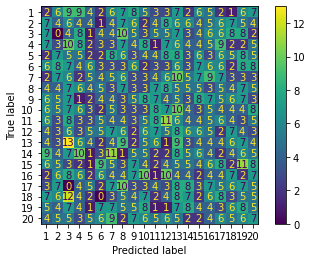

Classification Report
              precision    recall  f1-score   support

           1       0.02      0.02      0.02       100
           2       0.04      0.04      0.04       100
           3       0.03      0.04      0.03       100
           4       0.08      0.08      0.08       100
           5       0.03      0.02      0.02       100
           6       0.04      0.03      0.03       100
           7       0.05      0.05      0.05       100
           8       0.06      0.07      0.07       100
           9       0.05      0.05      0.05       100
          10       0.03      0.03      0.03       100
          11       0.10      0.08      0.09       100
          12       0.05      0.05      0.05       100
          13       0.07      0.09      0.08       100
          14       0.06      0.05      0.05       100
          15       0.04      0.04      0.04       100
          16       0.04      0.04      0.04       100
          17       0.05      0.05      0.05       100
     

In [9]:
Y_pred = model.predict_generator(test_dataset, 1157)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
disp = ConfusionMatrixDisplay(confusion_matrix(test_dataset.classes, y_pred),display_labels=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'])
disp.plot()
plt.show()
print('Classification Report')
target_names = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']
print(classification_report(test_dataset.classes, y_pred, target_names=target_names))